## Model fitting

In [19]:
import torch
import numpy as np
import scipy
import pickle
from pandas import read_csv
from matplotlib import pyplot as plt
from sbi import utils as utils

### Mortality 

In [16]:
from mortality.simulator import simulator

# Read in mortality observations
fn = 'mortality/observations/mortality.csv'
mortality_o = read_csv(fn, header=None)
mortality_o[0] = [round(v) for v in mortality_o[0]]
# Define census years
census_yrs = [2,6,8,11,14]

# Get mean value of morality params over a bunch of posterior samples
pr = 'mortality'
num_posterior_samples = 1000
with open(pr+'/prior.pkl', 'rb') as handle:
    prior = pickle.load(handle)
prior, theta_numel, prior_returns_numpy = utils.user_input_checks.process_prior(prior)
simulator = utils.user_input_checks.process_simulator(simulator, prior, is_numpy_simulator=True)
x_o = np.load(pr+'/observations/observations.npy')
x_o = torch.Tensor(x_o)
with open(pr+"/posterior.pkl", "rb") as handle:
    posterior = pickle.load(handle)
posterior_samples = posterior.sample(sample_shape=(1000,))
x_pp = simulator(posterior_samples)
x_pp = x_pp[~torch.any(x_pp.isnan(),dim=1)].numpy()
x_pp_mean = np.mean(x_pp, axis=0)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

/Volumes/External/Research/Regan/TecateCypress/model_fitting/mortality/simulator.py:79: RuntimeWarning: overflow encountered in exp
  dens_dep = ((nu_a[age_i])*(1-m_a[age_i])) / (1 + np.exp(-eta_a[age_i]*K_adult*(N/K_a[age_i] - A_o*h_o)))
/Volumes/External/Research/Regan/TecateCypress/model_fitting/mortality/simulator.py:79: RuntimeWarning: overflow encountered in exp
  dens_dep = ((nu_a[age_i])*(1-m_a[age_i])) / (1 + np.exp(-eta_a[age_i]*K_adult*(N/K_a[age_i] - A_o*h_o)))


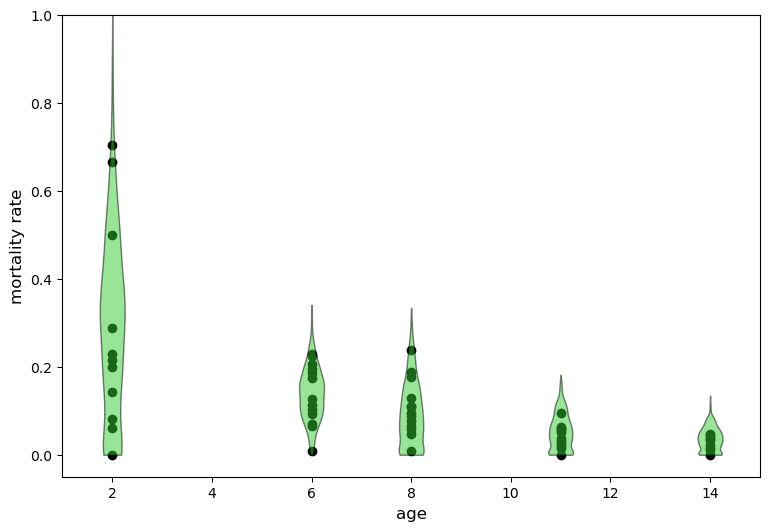

In [20]:
# Draw the distributions based on the above averages parameters for plotting
samples_per_census = 1000
all_y = []
for census_i, census_t in enumerate(census_yrs):
    mean = x_pp_mean[census_i]
    var = x_pp_mean[census_i + 5]
    skew = x_pp_mean[census_i + 10]
    dist_samples = scipy.stats.skewnorm.rvs(skew, loc=mean, scale=np.sqrt(var), size=samples_per_census)
    all_y.append(np.where(dist_samples<0, 0, dist_samples))

fig, ax = plt.subplots(1, figsize=(9,6))
ax_fontsize = 12

ax.scatter(mortality_o[0].to_numpy(), mortality_o[1].to_numpy(), color='k')

parts = ax.violinplot(all_y, positions=census_yrs, showextrema=False);
for pc in parts['bodies']:
    pc.set_facecolor('limegreen')
    pc.set_edgecolor('black')
    pc.set_alpha(0.5)

ax.set_ylim(-0.05, 1)
ax.set_xlim(1,15)
ax.set_ylabel("mortality rate", fontsize=ax_fontsize)
ax.set_xlabel("age", fontsize=ax_fontsize)
fn = f"sbi_figs/mortality_viz.png"
# fig.savefig(fn, bbox_inches='tight')

### Fecundity

In [30]:
from fecundity.simulator import simulator
import json

In [31]:
# Read in coarse grained fecundity observations
observations = np.load('fecundity/observations/observations.npy')
binwidth = 22
age_cntrs = np.array([binwidth*i + binwidth/2 for i in range(3)])

from fecundity.simulator import simulator
pr = 'fecundity'
x_o = np.load(pr+'/observations/observations.npy')
x_o = torch.Tensor(x_o)
with open(pr+"/posterior.pkl", "rb") as handle:
    posterior = pickle.load(handle)
posterior_samples = posterior.sample(sample_shape=(1000,)).numpy()
x_pp = np.ones((posterior_samples.shape[0], 7)) * np.nan
for sample_i, sample in enumerate(posterior_samples):
    x_pp[sample_i] = simulator(sample)
x_pp = x_pp[~np.any(np.isnan(x_pp), axis=1)]
x_pp_mean = np.mean(x_pp, axis=0)

# # Get mean value of fecundity params over a bunch of posterior samples
# from fecundity.simulator import simulator
# pr = 'fecundity'
# x_o = np.load(pr+'/observations/observations.npy')
# x_o = torch.Tensor(x_o)
# with open(pr+"/posterior.pkl", "rb") as handle:
#     posterior = pickle.load(handle)
# posterior_samples = posterior.sample(sample_shape=(1000,)).numpy()
# x_pp = np.ones((posterior_samples.shape[0], 7)) * np.nan
# for sample_i, sample in enumerate(posterior_samples):
#     x_pp[sample_i] = simulator(sample)
# x_pp = x_pp[~np.any(np.isnan(x_pp), axis=1)]
# x_pp_mean = np.mean(x_pp, axis=0)

# Try just looking at map instead
with open('../model_fitting/fecundity/map.json', 'r') as handle:
    fecundity_map = json.load(handle)
map_params = np.array(list(fecundity_map.values()))
x_pp = np.ones((posterior_samples.shape[0], 7)) * np.nan
for sample_i, sample in enumerate(posterior_samples):
    x_pp[sample_i] = simulator(map_params)
x_pp = x_pp[~np.any(np.isnan(x_pp), axis=1)]
x_pp_mean = np.mean(x_pp, axis=0)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

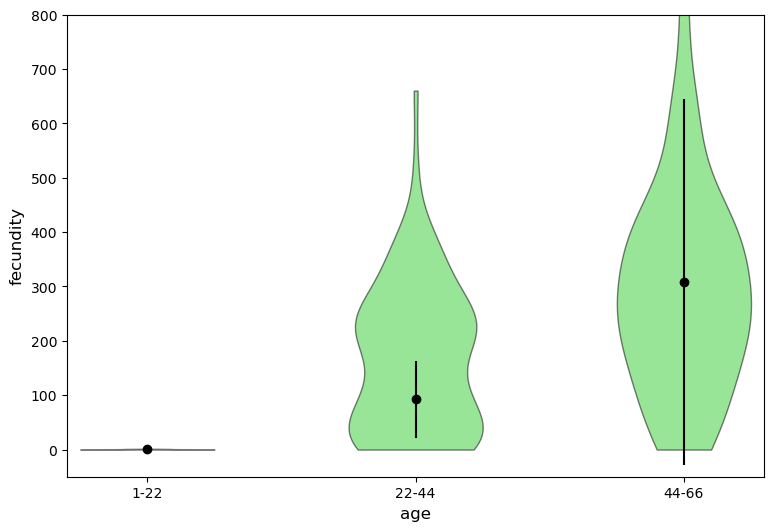

In [37]:
# Draw the distributions based on the above averages parameters for plotting
samples_per_census = 100
all_y = []
for census_i, census_t in enumerate(age_cntrs):
    mean = x_pp_mean[census_i]
    std = x_pp_mean[census_i + age_cntrs.size]
    dist_samples = scipy.stats.norm.rvs(loc=mean, scale=std, size=samples_per_census)
    all_y.append(np.where(dist_samples<0, 0, dist_samples))

fig, ax = plt.subplots(1, figsize=(9,6))
ax_fontsize = 12

ax.errorbar(range(3), observations[:age_cntrs.size], yerr=observations[age_cntrs.size:observations.size-1], 
            fmt='o', color='black')

parts = ax.violinplot(all_y, positions=range(3), showextrema=False, showmeans=False);
for pc in parts['bodies']:
    pc.set_facecolor('limegreen')
    pc.set_edgecolor('black')
    pc.set_alpha(0.5)
    
xtick_labels = [f"1-{binwidth}", f"{binwidth}-{2*binwidth}", f"{2*binwidth}-{3*binwidth}"]
ax.set_xticks(range(3), labels=xtick_labels)
ax.set_xlabel("age", fontsize=ax_fontsize)
ax.set_ylabel("fecundity", fontsize=ax_fontsize)
ax.set_ylim(-50, 800)
ax.set_xlim(-0.3, 2.3)
fn = f"sbi_figs/fecundity_viz.png"
fig.savefig(fn, bbox_inches='tight')